# WEB SCRAPING

In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup

from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys

import time

import numpy as np

Initially, we set on to try web scraping from two property website aggregators: Idealista and Imovirtual. Only the latter was possible, but we left our findings for Idealista below for reference.

## Idealista

In [64]:
url1="https://www.idealista.pt/areas/arrendar-casas/?shape=%28%28uni%7DFjv%7Dr%40%60%7BzEmwuFrqRncoEumnF%7Cre%40%29%29"
headers={"user-agent":"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/118.0.0.0 Safari/537.36"}
response=requests.get(url1,headers=headers)  
response
#soup=BeautifulSoup(response.content)

<Response [403]>

Let's try Selenium to see if it helps to bypass authorization issues

In [68]:
driver = webdriver.Edge()
driver.get(url1)
time.sleep(2)

In [ ]:
html = driver.page_source
soup = BeautifulSoup(html)
items = soup.find_all("div", attrs = {"class":"col-12 col-sm-6 col-md-6 col-lg-4 col-xl-3 result"})
len(items)

Idealista throws captcha to fill in even while using Selenium and then gives the error message below. Free APIs from Rapid API are timing out after extracting 56 pages, which is only 5% of all data listed on Idealista - too small a sample. Furthermore, we are expecting a lot of duplicates between Idealista and Imovirtual, since a lot of agents will be listing their properties on both website aggregators, so given all of the issues with Idealista, we can just leave Imovirtual as a sample.

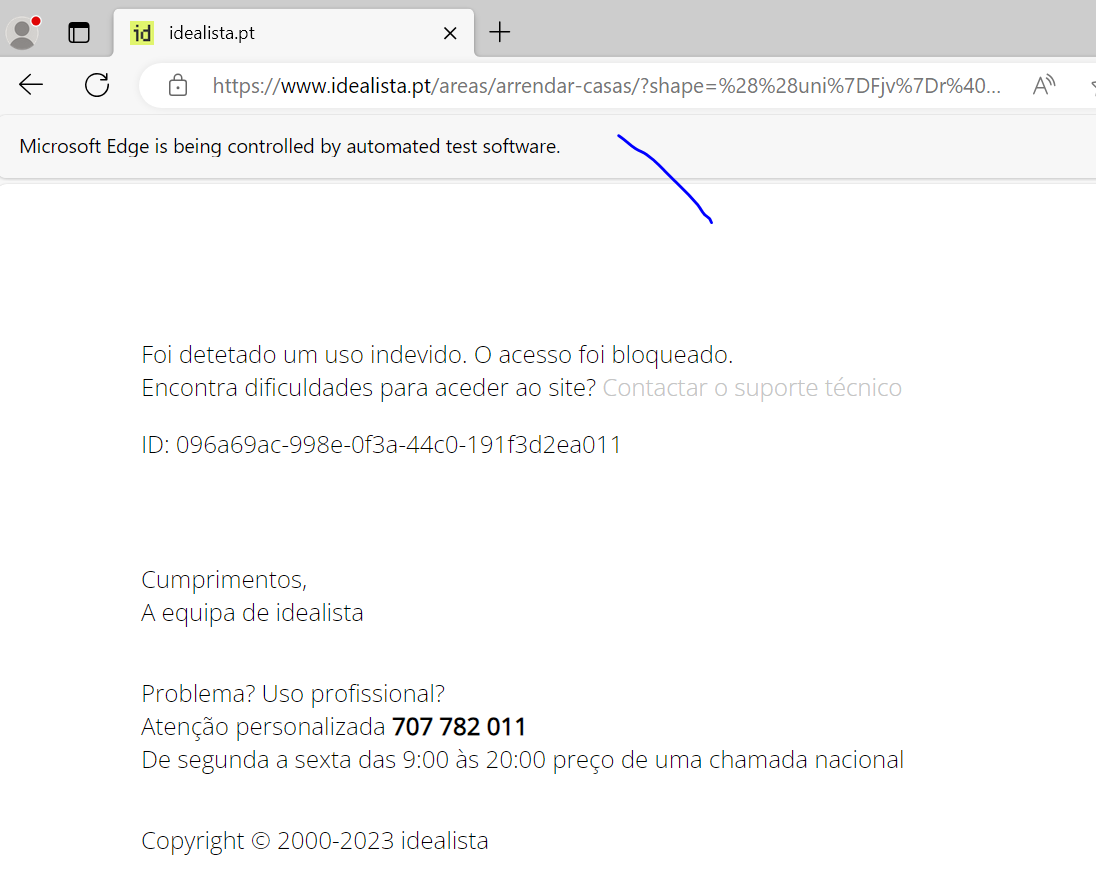

## Imovirtual

Getting the number of pages to scrape for buying and renting separately:

l_buy="https://www.imovirtual.com/comprar/"
l_rent="https://www.imovirtual.com/arrendar/"
headers={"user-agent":"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/118.0.0.0 Safari/537.36"}    
r_buy=requests.get(l_buy,headers=headers) 
r_rent=requests.get(l_rent,headers=headers) 
soup_buy=BeautifulSoup(r_buy.content)
soup_rent=BeautifulSoup(r_rent.content)

page_buy = soup_buy.a.get_text
page_buy


print(f"When showing 72 properties per page, there are ... pages to scrape:\n - Buying: {page_buy}\n - Renting: {page_rent})

Some ads do not have all of the attributes we are looking for below, so we resolve that with try-except blokes so that script does not fail on iteration through website pages: rooms, price, area, price_m2
<br>
Entries in those columns with N/A need to be cleaned during data formatting when joining all dataframes.

In [15]:
def imovirtual(property,type):
    #number of pages
    if type=="comprar" and property=="apartamento":
        n=1247
    elif type=="comprar" and property=="moradia":
        n=872
    elif type=="arrendar" and property=="apartamento":
        n=49
    else:
        n=12
    
    #adding an empty list of dataframes to append each df from a for loop
    dfs=[]

    for i in range(1,n+1):   
        url=f"https://www.imovirtual.com/{type}/{property}/?nrAdsPerPage=72&page={i}"
        headers={"user-agent":"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/118.0.0.0 Safari/537.36"}
        lag = np.random.default_rng().random()
        time.sleep(lag)
        response=requests.get(url,headers=headers) 

        soup=BeautifulSoup(response.content)
    
        imov_dict={}
        index=0

        ads = soup.find_all("article", attrs={"class":"offer-item"})
        for ad in ads:
            title=ad.find_all("span",attrs={"class":"offer-item-title"})[0].get_text().strip()
            try:
                rooms=ad.find_all("li",attrs={"class":"offer-item-rooms hidden-xs"})[0].get_text().strip()
            except:
                rooms="N/A"
            try:
                price=ad.find_all("li",attrs={"class":"offer-item-price"})[0].get_text().strip()
            except:
                price="N/A"
            try:
                area=ad.find_all("li",attrs={"class":"hidden-xs offer-item-area"})[0].get_text().strip()
            except:
                area="N/A"
            try:
                price_m2=ad.find_all("li",attrs={"class":"hidden-xs offer-item-price-per-m"})[0].get_text().strip()
            except:
                price_m2="N/A"
            location=ad.find_all("p",attrs={"class":"text-nowrap"})[0].get_text().strip()
            index+=1

            imov_dict[index]={"title":title,
                                "rooms":rooms,
                                "total_price":price,
                                "area":area,
                                "price_per_meter":price_m2,
                                "location":location
                                }
        df_imov=pd.DataFrame.from_dict(imov_dict,orient="index")
        
        #append df for each page to an existing list of dataframes
        dfs.append(df_imov)
    #concat a list of dfs from for loop
    return pd.concat(dfs)

   

Because we are dealing with almost 2200 pages across buying and renting categories and including a time lag of up to a second between each iteration, in order not to get blocked by Imovirtual, we load both dataframes once - running time circa 2h, broken into blocks between team members - and then save those results to csv files.
<br>
Takes too long to get dynamic data, and dynamic version of a dashboard is not available for public Tableau, so we can resort to csv anyway - fastest and easiest way for static connection to Tableau.

In [13]:
#SAVING DF ARRENDAR TO CSV
df_rent_ap=imovirtual(property="apartamento", type="arrendar")
df_rent_ap["Property"]="Apartment"
df_rent_mor=imovirtual(property="moradia", type="arrendar")
df_rent_mor["Property"]="House"

df_rent=pd.concat([df_rent_ap,df_rent_mor])

df_rent.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4282 entries, 1 to 1
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   title            4282 non-null   object
 1   rooms            4282 non-null   object
 2   total_price      4282 non-null   object
 3   area             4282 non-null   object
 4   price_per_meter  4282 non-null   object
 5   location         4282 non-null   object
 6   Property         4282 non-null   object
dtypes: object(7)
memory usage: 267.6+ KB


In [14]:
df_rent.to_csv("df_rent.csv")

In [ ]:
#SAVING DF COMPRAR TO CSV
df_buy_ap=imovirtual(property="apartamento", type="comprar")
df_buy_ap["Property"]="Apartment"
df_buy_mor=imovirtual(property="moradia", type="comprar")
df_buy_mor["Property"]="House"

df_buy=pd.concat([df_rent_ap,df_rent_mor])

df_buy.info()

# DATA WRANGLING

Assembling all data from csv files together into two dataframes: one for renting, one for buying

In [18]:
df_buy1=pd.read_csv("df_buy_mor.csv")
df_buy2=pd.read_csv("df_buy_ap.csv")
df_rent=pd.read_csv("df_rent.csv")
df_buy=pd.concat([df_buy1,df_buy2])

display(df_buy.info())
display(df_rent.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 152557 entries, 0 to 89783
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   Unnamed: 0       152557 non-null  int64 
 1   title            152557 non-null  object
 2   rooms            152557 non-null  object
 3   total_price      152557 non-null  object
 4   area             152557 non-null  object
 5   price_per_meter  88507 non-null   object
 6   location         152557 non-null  object
 7   Property         152557 non-null  object
dtypes: int64(1), object(7)
memory usage: 10.5+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4282 entries, 0 to 4281
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       4282 non-null   int64  
 1   title            4282 non-null   object 
 2   rooms            4282 non-null   object 
 3   total_price      4282 non-null   object 
 4   area             4282 non-null   object 
 5   price_per_meter  0 non-null      float64
 6   location         4282 non-null   object 
 7   Property         4282 non-null   object 
dtypes: float64(1), int64(1), object(6)
memory usage: 267.8+ KB


None

In [19]:
def cleaning(df):
    #cleaning away Preco sob consulta
    drop_index=df[df["total_price"]=="Preço sob consulta"].index
    df.drop(index=drop_index,inplace=True)

    #drop N/A in area
    drop_index=df[df["area"]=="N/A"].index
    df.drop(index=drop_index,inplace=True)

    #district
    df['district'] = df['location'].apply(lambda x: str(x).split(',')[-1])
    try:
        df['district']=df['district'].apply(lambda row: row.split(":")[-1])
    except:
        df['district']=df['district']
    
    #location
    try:
        df['location'] = df['location'].apply(lambda x: str(x).split(':')[1])
    except:
        df['location'] = df['location']
   
    #regex for numeric values
    df['total_price'] = df['total_price'].astype(str).str.extract(r'([\d\s]+)')[0].str.replace(" ","")
    df['total_price'] = df['total_price'].astype(float)
    df['area'] = df['area'].astype(str).str.extract(r'([\d]+)')
    df['area'] =df['area'].astype(float)

    #calculation price per meter
    df['price_per_meter'] = df["total_price"]/df['area']

    #resetting index
    df.reset_index(inplace=True)

    #dropping index column from csv file - won't be used
    df.drop(columns="Unnamed: 0",axis=1,inplace=True)

    return df


In [20]:
df_rent=cleaning(df_rent)
df_rent["type"]="Renting"

In [21]:
df_buy=cleaning(df_buy)
df_buy["type"]="Purchase"

## Mortgage Calculator

In order to compare the monthly prices of buying vs renting properties, we need to incorporate mortgage calculations into the monthly payment schedule.

We assume that we are going to loan the full amount for a period of 30 years, or 360 months. Avg interest rate in Portugal is 4% -- very broad assumptions and definitely room for improvement here.

Calculating monthly payment:

In [22]:
df_rent["monthly_payment"]=df_rent["total_price"]
df_buy["monthly_payment"]=df_buy["total_price"]*(0.04/12*(1+0.04/12)*360)/ ((1+0.04/12)*360-1)


In [23]:
df=pd.concat([df_buy,df_rent])
df.reset_index(inplace=True)

In [24]:
df.to_csv("df_clean.csv",index=False)

In [34]:
df_rent[df_rent["total_price"]>=10000]

,index,title,rooms,total_price,area,price_per_meter,location,Property,district,type,monthly_payment
51,51,"Apartamento T2 à venda na Rua da Flora, 45, Lo...",T2,465000.0,84.0,5535.714286,"Carcavelos e Parede, Cascais, Lisboa",Apartment,Lisboa,Renting,465000.0
58,58,APARTAMENTO T2 NO MONTIJO,T2,250000.0,85.0,2941.176471,"Montijo e Afonsoeiro, Montijo, Setúbal",Apartment,Setúbal,Renting,250000.0
74,74,Apartamento T4+2 para arrendamento no Príncipe...,T4,10700.0,315.0,33.968254,"Misericórdia, Lisboa",Apartment,Lisboa,Renting,10700.0
126,126,"Apartamento T3 mobilado para arrendar, no Atlâ...",T3,14000.0,214.0,65.420561,"Cascais e Estoril, Cascais, Lisboa",Apartment,Lisboa,Renting,14000.0
211,211,"Excelente T2 luminoso, com elevador, 1 lugar d...",T2,255000.0,75.0,3400.000000,"Casal de Cambra, Sintra, Lisboa",Apartment,Lisboa,Renting,255000.0
...,...,...,...,...,...,...,...,...,...,...,...
4124,4142,Moradia para reconstruir,T4,450000.0,308.0,1461.038961,"Paranhos, Porto",House,Porto,Renting,450000.0
4151,4170,Moradia T6 no Estoril,T6,10500.0,380.0,27.631579,"Cascais e Estoril, Cascais, Lisboa",House,Lisboa,Renting,10500.0
4234,4254,"Moradia para alugar … festas , batizados etc e...",T3,12345.0,240.0,51.437500,"Recarei, Paredes, Porto",House,Porto,Renting,12345.0
4241,4261,Espaco com 130 m2,T1,100000.0,130.0,769.230769,"Atães e Rendufe, Guimarães, Braga",House,Braga,Renting,100000.0
